# **LSTM Autoencoder 기반 클러스터링을 이용한 시계열 표준 패턴 추출 (3)**

### 창원대 전자공학과 20145234 황주효 (Hwang Ju-hyo, Department of Electronic Engineering, Changwon University)
---

과정은 다음과 같다.
1. 기준 패턴 설정 및 유사 패턴 추출
2. LSTM Autoencoder 모델링 및 학습
3. T-SNE 및 UMAP 압축, 시각화 비교, k-memoids 클러스터링 및 표준 패턴 플로팅

## **3. T-SNE 및 UMAP 압축 및 시각화 비교, k-memoids 클러스터링 및 표준 패턴 플로팅**
---

* Encoder의 출력 데이터를 T-SNE 및 UMAP을 사용해 차원 축소를 하고 K-memoids 클러스터링 수행 및 오토인코더 사용 전 데이터로 DTW 클러스터링을 수행한 후 비교해본다.

* 데이터 및 모델 불러오기

In [11]:
import pickle
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np

with open("data.pickle","rb") as fr:
    
    X = pickle.load(fr)
    
np.random.seed(77)
np.random.shuffle(X)

In [12]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.load_model('cnn_autoencoder.h5')
model2 = keras.models.load_model('cnn_encoder.h5')

### T-SNE 시각화

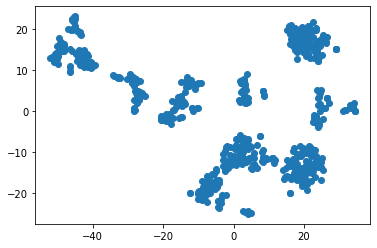

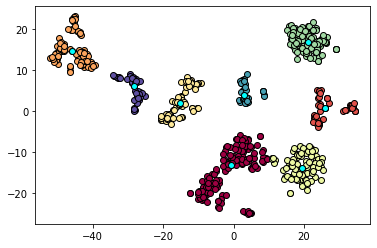

In [13]:
from sklearn_extra.cluster import KMedoids
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

Y = model2.predict(X).reshape(600, 20)
tsne = TSNE(learning_rate=300, n_components=2)
transformed = tsne.fit_transform(Y)

fig = plt.figure()
plt.scatter(transformed.T[0], transformed.T[1])
plt.show()

km = KMedoids(n_clusters=8, init = 'k-medoids++', max_iter = 300)
cobj = km.fit(transformed)
t = km.fit_predict(transformed)
labels = cobj.labels_

unique_labels = set(labels)
colors = [
    plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))
]
for k, col in zip(unique_labels, colors):

    class_member_mask = labels == k

    xy = transformed[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.plot(
    cobj.cluster_centers_[:, 0],
    cobj.cluster_centers_[:, 1],
    "o",
    markerfacecolor="cyan",
    markeredgecolor="k",
    markersize=6,
)
plt.show()

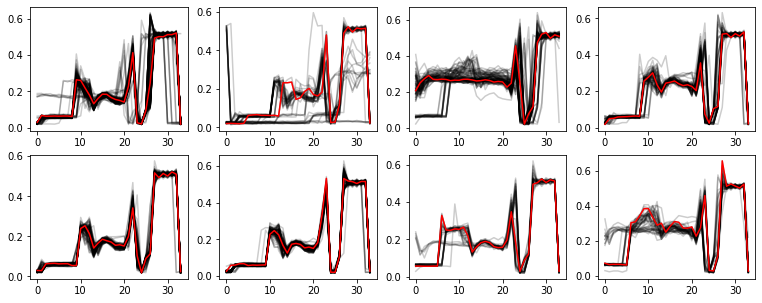

In [14]:
fig, ax = plt.subplots(2, 4, figsize=(13, 5))

for yi in range(4):
    for xx in X[t == yi]:
        ax[0][yi].plot(xx.ravel(), "k-", alpha=.2)
    ax[0][yi].plot(X[np.where(transformed == cobj.cluster_centers_[yi])[0][0]], 'r-')
        
for yi in range(4, 8):
    for xx in X[t == yi]:
        ax[1][yi-4].plot(xx.ravel(), "k-", alpha=.2)
    ax[1][yi-4].plot(X[np.where(transformed == cobj.cluster_centers_[yi])[0][0]], 'r-')
plt.show()

### UMAP 시각화

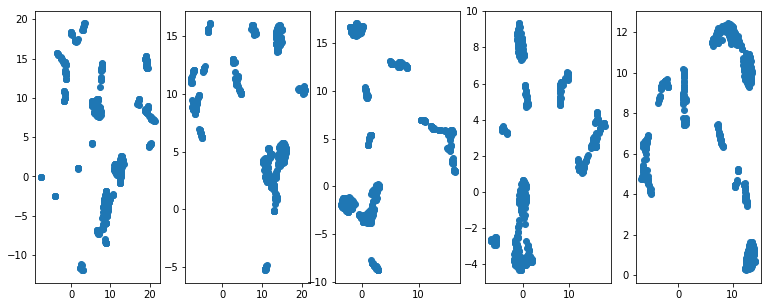

In [15]:
import umap

fig, ax = plt.subplots(1, 5, figsize=(13, 5))
for i in range(5):
    embedding = umap.UMAP(n_neighbors = (i+1)*5,n_epochs = 500).fit_transform(Y)
    ax[i].scatter(embedding.T[0], embedding.T[1])
plt.show()

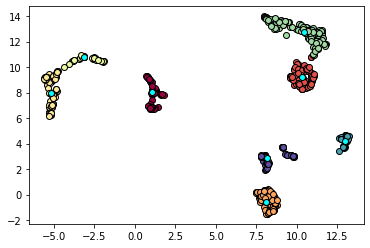

In [16]:
km2 = KMedoids(n_clusters=8, init = 'k-medoids++', max_iter = 300)
embedding = umap.UMAP(n_neighbors = 25,n_epochs = 500).fit_transform(Y)
cobj2 = km2.fit(embedding)
t2 = km2.fit_predict(embedding)
labels = cobj2.labels_

unique_labels = set(labels)
colors = [
    plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))
]
for k, col in zip(unique_labels, colors):

    class_member_mask = labels == k

    xy = embedding[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.plot(
    cobj2.cluster_centers_[:, 0],
    cobj2.cluster_centers_[:, 1],
    "o",
    markerfacecolor="cyan",
    markeredgecolor="k",
    markersize=6,
)
plt.show()

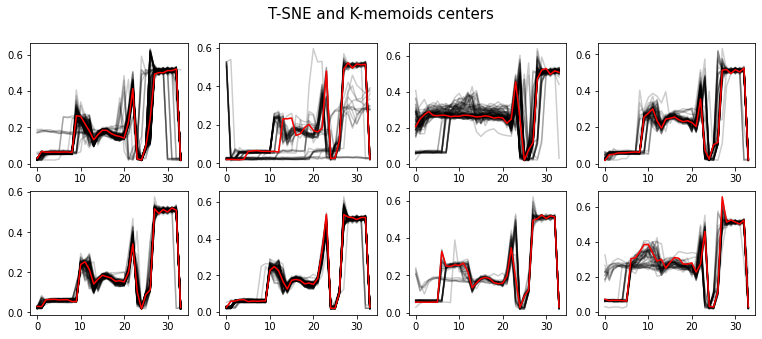

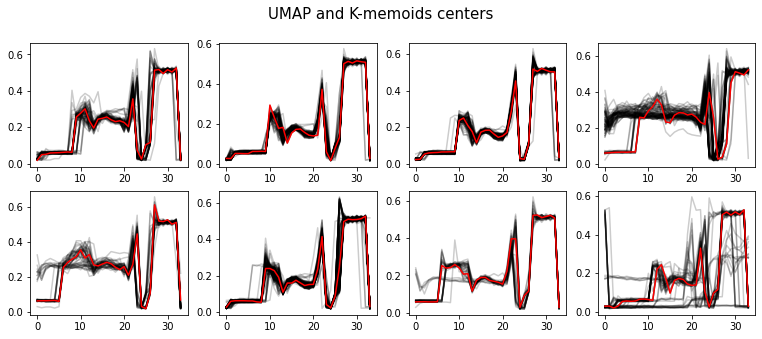

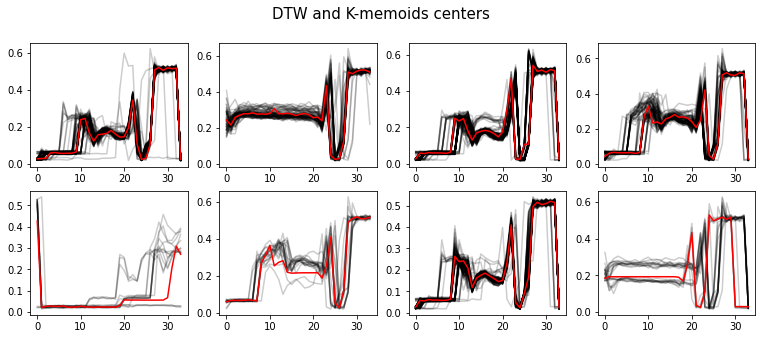

In [17]:
fig, ax = plt.subplots(2, 4, figsize=(13, 5))

for yi in range(4):
    for xx in X[t == yi]:
        ax[0][yi].plot(xx.ravel(), "k-", alpha=.2)
    ax[0][yi].plot(X[np.where(transformed == cobj.cluster_centers_[yi])[0][0]], 'r-')
        
for yi in range(4, 8):
    for xx in X[t == yi]:
        ax[1][yi-4].plot(xx.ravel(), "k-", alpha=.2)
    ax[1][yi-4].plot(X[np.where(transformed == cobj.cluster_centers_[yi])[0][0]], 'r-')
plt.suptitle('T-SNE and K-memoids centers', fontsize = 15 )
plt.show()


fig, ax = plt.subplots(2, 4, figsize=(13, 5))

for yi in range(4):
    for xx in X[t2 == yi]:
        ax[0][yi].plot(xx.ravel(), "k-", alpha=.2)
    ax[0][yi].plot(X[np.where(embedding == cobj2.cluster_centers_[yi])[0][0]], 'r-')

for yi in range(4, 8):
    for xx in X[t2 == yi]:
        ax[1][yi-4].plot(xx.ravel(), "k-", alpha=.2)
    ax[1][yi-4].plot(X[np.where(embedding == cobj2.cluster_centers_[yi])[0][0]], 'r-')
plt.suptitle('UMAP and K-memoids centers', fontsize = 15)
plt.show()

from tslearn.clustering import TimeSeriesKMeans
km3 = TimeSeriesKMeans(n_clusters = 8, metric = 'dtw', max_iter = 50).fit(X)

Y3 = km3.fit_predict(X)

fig, ax = plt.subplots(2, 4, figsize=(13, 5))
for yi in range(4):
    for xx in X[Y3 == yi]:
        ax[0][yi].plot(xx.ravel(), "k-", alpha=.2)
    ax[0][yi].plot(km3.cluster_centers_[yi].ravel(), "r-")
    
for yi in range(4, 8):
    for xx in X[Y3 == yi]:
        ax[1][yi-4].plot(xx.ravel(), "k-", alpha=.2)
    ax[1][yi-4].plot(km3.cluster_centers_[yi].ravel(), "r-")
plt.suptitle('DTW and K-memoids centers', fontsize = 15)
plt.show()

## 3D 시각화 (T-SNE)

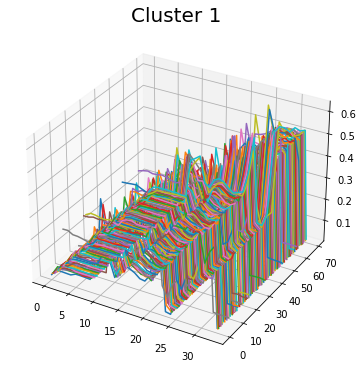

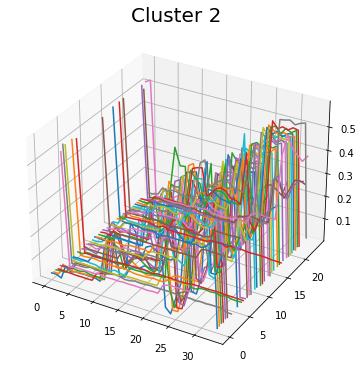

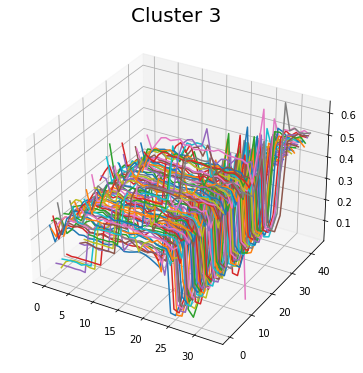

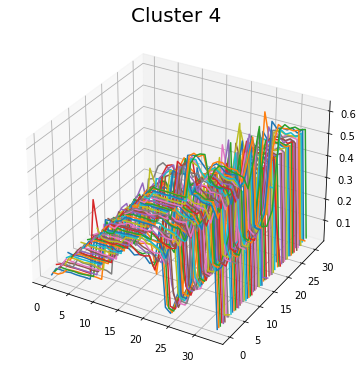

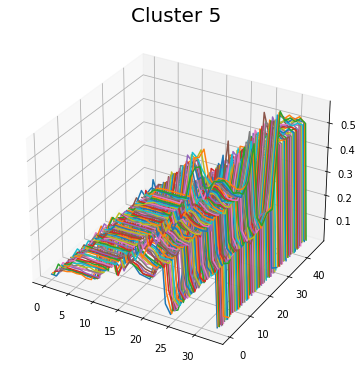

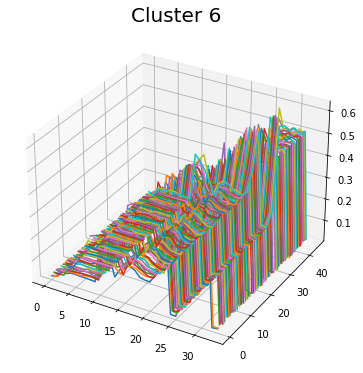

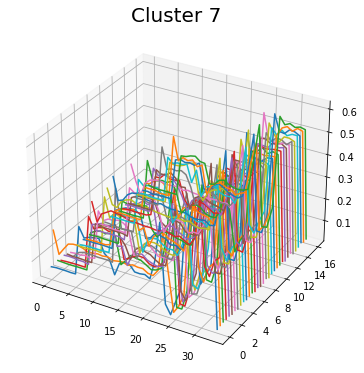

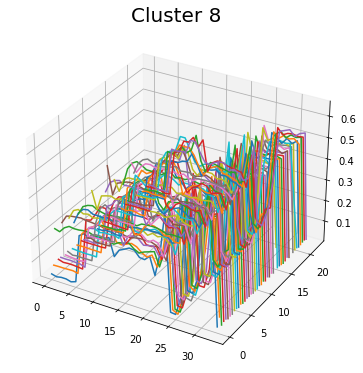

In [18]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
for i in range(8):
    fig = plt.figure(figsize = (5, 5))
    ax = fig.gca(projection='3d')

    zs = 0
    for xx in X[t == i]:
        ax.plot(range(len(X[0])),xx, zs=zs,zdir = 'y')
        zs = zs+0.5
    plt.tight_layout()
    plt.title('Cluster {}'.format(i+1),{'fontsize' : 20})
    plt.show()

## 3D 시각화 (UMAP)

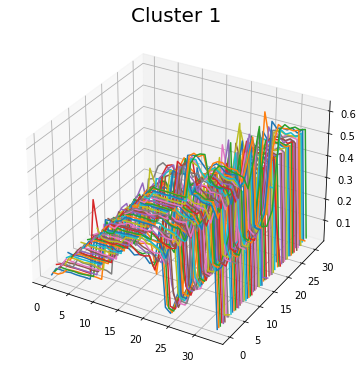

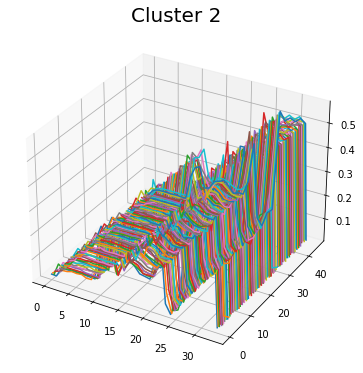

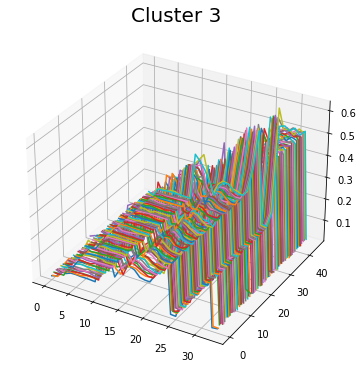

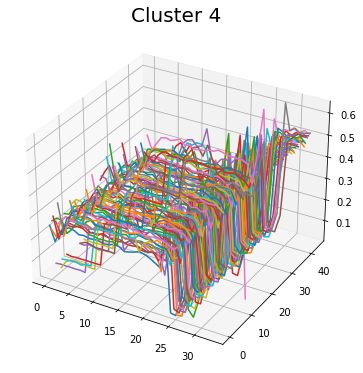

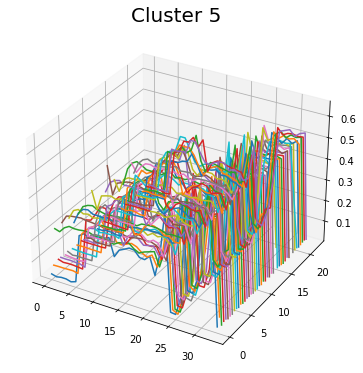

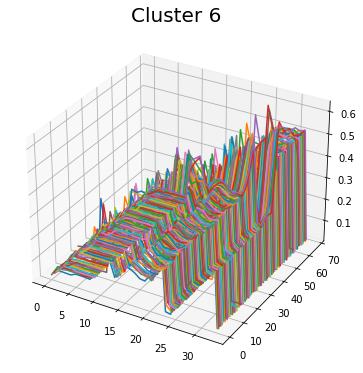

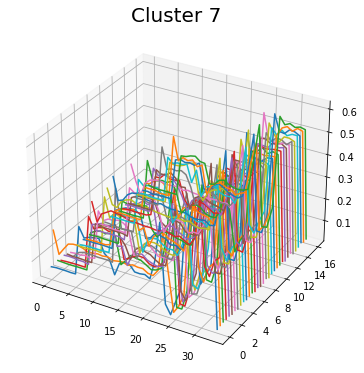

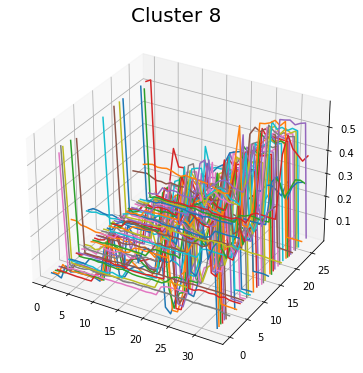

In [19]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
for i in range(8):
    fig = plt.figure(figsize = (5, 5))
    ax = fig.gca(projection='3d')

    zs = 0
    for xx in X[t2 == i]:
        ax.plot(range(len(X[0])),xx, zs=zs,zdir = 'y')
        zs = zs+0.5
    plt.tight_layout()
    plt.title('Cluster {}'.format(i+1),{'fontsize' : 20})
    plt.show()

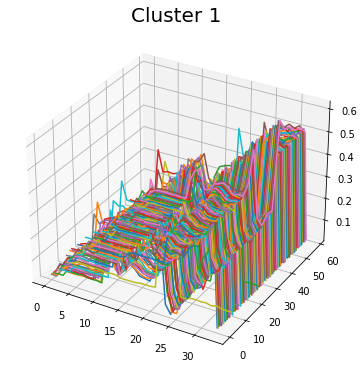

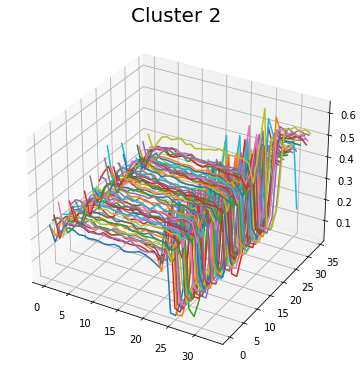

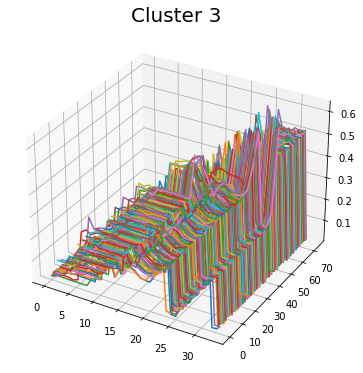

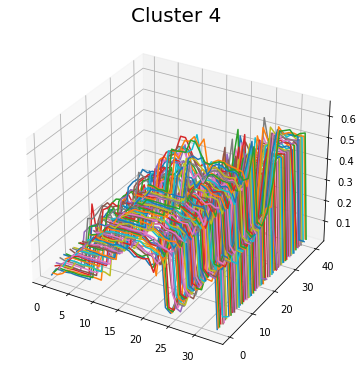

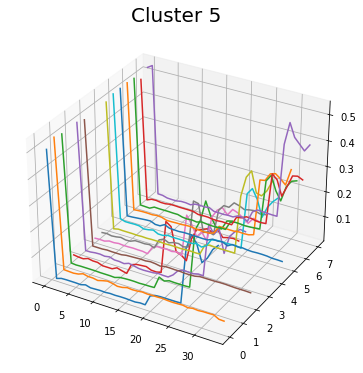

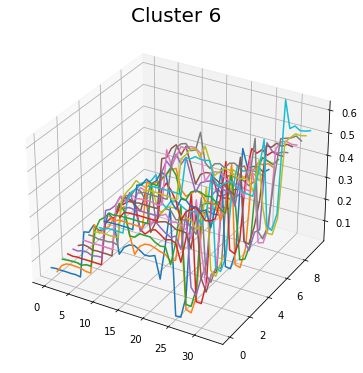

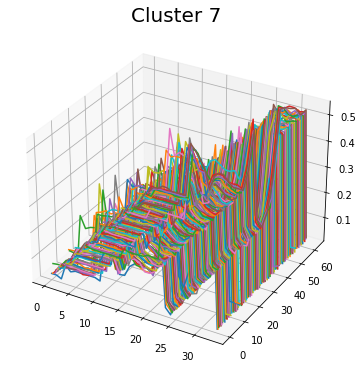

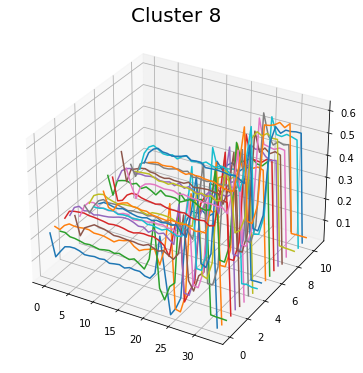

In [20]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
for i in range(8):
    fig = plt.figure(figsize = (5, 5))
    ax = fig.gca(projection='3d')

    zs = 0
    for xx in X[Y3 == i]:
        ax.plot(range(len(X[0])),xx, zs=zs,zdir = 'y')
        zs = zs+0.5
    plt.tight_layout()
    plt.title('Cluster {}'.format(i+1),{'fontsize' : 20})
    plt.show()